In [1]:
import time
import cv2
import os
import sys
import torch
import copy
import queue
import glob
import math
import threading
import numpy as np
import torch.nn as nn
from torch.backends import cudnn
from backbone import EfficientDetBackbone
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess,sirxiapreprocess
from scipy.spatial.distance import pdist

In [2]:
class efficientdet:
    def __init__(self,compound_coef,force_input_size = 1920,huamanNum=1,dir_path='./walkingworkspace/train_all',NUM_EIGEN_FACES= 128):
        self.humanNum=huamanNum
        cudnn.fastest = True
        cudnn.benchmark = True
        self.bbox_threshold=0.01#%bbox的阈值!<
        self.probability_threshold=0.3#%人体识别概率的阈值!<
        self.use_cuda = True 
        self.use_float16 = False
        self.threshold = 0.2
        self.iou_threshold = 0.2
        self.obj_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
            'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
            'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie',
            'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
            'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv',
            'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
            'refrigerator', '', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
            'toothbrush']
        #self.device = torch.device('cuda')
        self.model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(self.obj_list))
        self.model.load_state_dict(torch.load(f'weights/efficientdet-d{compound_coef}.pth'))
        self.model.requires_grad_(False)
        self.model.eval()
        #self.model=nn.DataParallel(self.model)
        self.model.cuda()
        input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
        self.input_size =  force_input_size
        self.t=time.time()
        self.pca=PCA(dir_path,NUM_EIGEN_FACES)
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.out = cv2.VideoWriter('output.avi',fourcc, 30.0, (640,480))
    def init_video(self):
        self.out.release()
        self.pca.clear_id()
        self.pca.frame=0
        name = time.strftime('%Y.%m.%d',time.localtime(time.time()))
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.out = cv2.VideoWriter(name+'.avi',fourcc, 30.0, (640,480))
    def threadStart(self):
        threadone=threading.Thread(target=self.mythread,args=())
        threadone.start()
      
    def mythread(self):
        global data_queue,out_queue
        print('start thread ->>> efficientdet ')
        while True:
            self.t=time.time()
            while(data_queue.qsize()<2):
                time.sleep(0.01)
                if time.time()-self.t>10:
                    print('stop thread ->>> efficientdet ')
                    break
            out_queue.put(self.detector(data_queue.get()))
                            ##################
                            ####detector######
                            ##################
    def  detector(self,im):
        ori_imgs, framed_imgs, framed_metas = sirxiapreprocess(im, max_size=self.input_size)
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
        x = x.to(torch.float32 if not self.use_float16 else torch.float16).permute(0, 3, 1, 2)
        with torch.no_grad():
            features, regression, classification, anchors = self.model(x)
            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()
            out = postprocess(x,
                              anchors, regression, classification,
                              regressBoxes, clipBoxes,
                              self.threshold, self.iou_threshold)
            out = invert_affine(framed_metas, out)
            bbox_list,c_list=self.update(out, ori_imgs)
            #print(bbox_list,c_list)
            #identities,bbox_xyxy = DeepSort.deep_sort(np.asarray(bbox_list),np.asarray(c_list),im)
            identities,dths,color = self.pca.efficientdet_compute_pca(bbox_list,c_list,im)
            im =self.display(bbox_list,c_list ,im,identities,dths,color)
            self.out.write(im)
            self.t=time.time()
            cv2.waitKey(1)
            #return identities,bbox_xyxy,c_list
            #return bbox_list,c_list ,identities
    #过滤
    def update(self,preds, imgs):
        save_list=[]
        area_list=[]
        score_list=[]
        for i in range(len(imgs)):
            if len(preds[i]['rois']) == 0:
                continue
            for j in range(len(preds[i]['rois'])):
                if preds[i]['class_ids'][j]==0:#person
                    score = float(preds[i]['scores'][j])#百分比
                    H,W=imgs[i].shape[:2]
                    (x1, y1, x2, y2) = preds[i]['rois'][j].astype(np.int)
                    area = (x2-x1)*(y2-y1)
                    if  (area/H*W)<self.bbox_threshold or score<self.probability_threshold:
                        continue
                    x,y,w,h=(x1+x2)/2,(y1+y2)/2,abs(x1-x2),abs(y1-y2)
                    area_list.append(area)
                    save_list.append([x,y,w,h]) 
                    score_list.append(score)
        bbox_list,c_list=[],[]
        if len(area_list)>self.humanNum:
            
            for i in range(self.humanNum):
                one=save_list[area_list.index(max(area_list))]
                two=score_list[area_list.index(max(area_list))]
                bbox_list.append(copy.copy(one))
                c_list.append(copy.copy(two))
                save_list.remove(one)
                score_list.remove(two)
                area_list.remove(max(area_list))
                 
        else:
            for i in range(len(area_list)):
                one=save_list[area_list.index(max(area_list))]
                two=score_list[area_list.index(max(area_list))]
                bbox_list.append(copy.copy(one))
                c_list.append(copy.copy(two))
                save_list.remove(one)
                score_list.remove(two)
                area_list.remove(max(area_list))
        return bbox_list,c_list
    
    def display(self,bbox_list,c_list,im,identities,dths,color):
        #print(len(out_list))
        for bbox,c,id_,dth,color_ in zip(bbox_list,c_list,identities,dths,color):
            #(x1, y1, x2, y2) = bbox
            (x, y, w, h) = bbox
            (x1, y1, x2, y2)=int(x-w/2), int(y-h/2), int(x+w/2), int(y+h/2)
            cv2.rectangle(im, (x1, y1), (x2, y2), (color_, 0, 255-color_), 2)
            #cv2.putText(im, ('%.2f'%c), (x2+10, y1+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 250,0), 1)
            cv2.putText(im, ('%.2f'%dth), (x2+10, y1+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (color_, 0, 255-color_), 1)
            cv2.putText(im, ('%s'%id_), (x1, y1+25), cv2.FONT_HERSHEY_SIMPLEX, 1, (color_, 0, 255-color_), 1)
        fps = 1/(time.time()-self.t)
        cv2.putText(im, ('%.2f'%fps), (590, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        cv2.imshow('efficientdet', im)
        return im

In [3]:
from torchvision.models.segmentation import fcn_resnet101
from PIL import Image
from torchvision import transforms
from scipy.optimize import linear_sum_assignment
class PCA:
    def __init__(self,dir_path='./test_colors/train',NUM_EIGEN_FACES = 64):
        self.save={'000':{'center':[],'bbox':[],'lib':[],'frame':0,'passage':False}}
        self.NUM_EIGEN_FACES = NUM_EIGEN_FACES
        self.images = self.readImages(dir_path)
        self.data = self.createDataMatrix(self.images)
        #self.data = torch.from_numpy(self.data).cuda()
        #torch.pca_lowrank(A, q=None, center=True, niter=2)
        #self.mean, self.eigenVectors = torch.pca_lowrank(self.data, q=None, center=True, niter= self.NUM_EIGEN_FACES)
        #self.means, self.eigenVectorses=[],[]
        #print('the alldata %d'%len(self.eigenVectors))
        #self.init_pca(basepath)
        #self.notebook={'000':{'frame':[],'lib':[]}}
        self.frame=0
        self.flag_frame=[]
        self.flag_line=[]
        self.dth = 0.5#相似度距离0.6  / 欧氏距离25
        self.Forget=10  #状态切换帧
        self.testsave={}
        self.models_mean = './models/mean.npy'
        self.models_eigenVector = './models/eigenVector.npy'
        #self.meta = threading.Lock()
        if os.path.exists(self.models_mean)==False and os.path.exists(self.models_eigenVector)==False:
            self.mean, self.eigenVectors = cv2.PCACompute(self.data, mean=None, maxComponents=self.NUM_EIGEN_FACES)
            np.save(self.models_mean,self.mean)
            np.save(self.models_eigenVector,self.eigenVectors)
        else:
            self.mean=np.load(self.models_mean)
            self.eigenVectors=np.load(self.models_eigenVector)
        
    def createDataMatrix(self,images):
        numImages = len(images)
        sz = images[0].shape
        data = np.zeros((numImages, sz[0] * sz[1] * sz[2]), dtype=np.float32)
        for i in range(0, numImages):
            image = images[i].flatten()
            data[i,:] = image
        #print("createData ok")
        return data

    def readImages(self,path):
        print("Reading images from " + path, end="...")
        # Create array of array of images.
        images = []
        # List all files in the directory and read points from text files one by one
        for name in glob.glob(path+'/*'):
            for imagePath in glob.glob(name+'/*.jpg'):
                    # Add to array of images
                    im = cv2.imread(imagePath)
                    im = cv2.resize(im,(64,128))
                    if im is None :
                        print("image:{} not read properly".format(imagePath))
                    else :
                        # Convert image to floating point
                        im = np.float32(im)/255.0
                        # Add image to list
                        images.append(im)
                        # Flip image 
                        imFlip = cv2.flip(im, 1);
                        # Append flipped image
                        #images.append(imFlip)
        numImages = int(len(images))
        # Exit if no image found
        if numImages == 0 :
            print("No images found")
            sys.exit(0)
        print(str(numImages) + " files read.")
        return images
#*
#*
#*      算法集合
#*
#*
    def compute_cos(self,x,y):
        x_,y_=x.flatten(),y.flatten()
        dist =1- abs(np.dot(x_,y_)/(np.linalg.norm(x_)*np.linalg.norm(y_)))      
        return abs(dist)
    
    def compute_dis(self,x,y):
         return np.linalg.norm( x - y )
    
    def compute_Maha(self,x,y):
        X=np.vstack([x,y])
        XT=X.T
        S=np.cov(X)   #两个维度之间协方差矩阵
        SI = np.linalg.inv(S) #协方差矩阵的逆矩阵
        #马氏距离计算两个样本之间的距离，此处共有10个样本，两两组合，共有45个距离。
        n=XT.shape[0]
        d1=[]
        for i in range(0,n):
            for j in range(i+1,n):
                delta=XT[i]-XT[j]
                d=np.sqrt(np.dot(np.dot(delta,SI),delta.T))
                d1.append(d)
        return d1
    
    def computer_Hungary(self,task_matrix):
        b = task_matrix.copy()
        # 行和列减0
        for i in range(len(b)):
            row_min = np.min(b[i])
            for j in range(len(b[i])):
                b[i][j] -= row_min
        for i in range(len(b[0])):
            col_min = np.min(b[:, i])
            for j in range(len(b)):
                b[j][i] -= col_min
        line_count = 0
        # 线数目小于矩阵长度时，进行循环
        while (line_count < len(b)):
            line_count = 0
            row_zero_count = []
            col_zero_count = []
            for i in range(len(b)):
                row_zero_count.append(np.sum(b[i] == 0))
            for i in range(len(b[0])):
                col_zero_count.append((np.sum(b[:, i] == 0)))
            # 划线的顺序（分行或列）
            line_order = []
            row_or_col = []
            for i in range(len(b[0]), 0, -1):
                while (i in row_zero_count):
                    line_order.append(row_zero_count.index(i))
                    row_or_col.append(0)
                    row_zero_count[row_zero_count.index(i)] = 0
                while (i in col_zero_count):
                    line_order.append(col_zero_count.index(i))
                    row_or_col.append(1)
                    col_zero_count[col_zero_count.index(i)] = 0
            # 画线覆盖0，并得到行减最小值，列加最小值后的矩阵
            delete_count_of_row = []
            delete_count_of_rol = []
            row_and_col = [i for i in range(len(b))]
            for i in range(len(line_order)):
                if row_or_col[i] == 0:
                    delete_count_of_row.append(line_order[i])
                else:
                    delete_count_of_rol.append(line_order[i])
                c = np.delete(b, delete_count_of_row, axis=0)
                c = np.delete(c, delete_count_of_rol, axis=1)
                line_count = len(delete_count_of_row) + len(delete_count_of_rol)
                # 线数目等于矩阵长度时，跳出
                if line_count == len(b):
                    break
                # 判断是否画线覆盖所有0，若覆盖，进行加减操作
                if 0 not in c:
                    row_sub = list(set(row_and_col) - set(delete_count_of_row))
                    min_value = np.min(c)
                    for i in row_sub:
                        b[i] = b[i] - min_value
                    for i in delete_count_of_rol:
                        b[:, i] = b[:, i] + min_value
                    break
        row_ind, col_ind = linear_sum_assignment(b)
        min_cost = task_matrix[row_ind, col_ind].sum()
        best_solution = list(task_matrix[row_ind, col_ind])
        return  best_solution
     #计算两点近距离公式 
    def distEclud(self,veA,vecA,veB,vecB):
        lossA=veB-veA
        lossB=vecB-vecA
        return math.sqrt(pow(lossA,2)+pow(lossB,2))
#*
#*
#*      功能函数
#*
#*
    def clear_id(self):
        self.save={'000':{'center':[],'bbox':[],'lib':[],'frame':0,'passage':False}}
        
    def manage_lib(self,frame):
        for k,v in list(self.save.items()):
            if k=='000':#or v['passage']==False:
                continue
            lib = v['lib']
            frame_lib=v['frame']
            if frame-frame_lib>self.Forget:
                self.save[k]['frame']=frame
                #self.save[k]['lib'].pop(0)
                if len(lib)<10:
                    self.dele_lib_id(k)
                if  k not in self.save:
                    continue
                if self.save[k]['passage']==True:
                    center =self.save[k]['lib'][0]
                    for lib_ in self.save[k]['lib']:
                        center=center*0.5+lib_*0.5
                    #self.save[k]['lib'].pop(0)
                    self.passage_off(k,center)
                    #self.flag_frame=[]
                    
    def paassag_on(self,feature,bbox,frame,id_):
        self.save[id_]['center']=feature
        self.save[id_]['bbox']=bbox
        self.save[id_]['lib'].append(feature)
        self.save[id_]['frame']=frame
        self.save[id_]['passage']=True
        print('%s passage is True'%id_)
        
    def passage_off(self,id_,center):
        self.save[id_]['center']=center
        self.save[id_]['passage']=False
        print('%s passage is False'%id_)
        
    def update_frame(self,id_,frame):
        self.save[id_]['frame']=frame
        
    def dele_lib_id(self,id_):
        del self.save[id_]
        print('the id %s Remove'%id_)
        
    def add_lib(self,feature,bbox,frame,passage=False):
        save={'center':[],'bbox':[],'lib':[],'frame':0,'passage':False}
        for n in  self.save.keys():
            id_=n
        self.id_new=('%03d'%(int(id_)+1))
        save['center']=feature
        save['bbox']=bbox
        save['lib']=[feature]
        save['frame']=frame
        save['passage']=passage
        self.save[self.id_new]=save
        print('find id %s'%self.id_new)
        return self.id_new
    
    def add_id(self,feature,bbox,frame):   
        #print(len(self.save))
        if frame!=0 and len(self.save)!=1:
            id_ = self.check_lib_passage(feature)
            #self.id_new = self.check_lib(feature)
            if id_ == ' ':
                self.flag_line=[]
                if self.id_new in self.save:
                    if frame-self.save[self.id_new]['frame']>1:
                        self.flag_frame=[]
                else:
                    self.flag_frame=[]
                if len(self.flag_frame)==0:
                    self.id_new = self.add_lib(feature,bbox,frame)
                self.flag_frame.append(frame)
                self.save[self.id_new]['frame']=frame
                #self.update_frame
                if len(self.flag_frame)>=5:
                    if np.mean(self.flag_frame)==self.flag_frame[2]:
                        self.paassag_on(feature,bbox,frame,self.id_new)
                        self.flag_frame=[]
                    else:
                        self.dele_lib_id(self.id_new)
                        self.flag_frame=[]
            else:
                #if frame - self.save[id_]['frame'] >3:
                self.flag_frame=[]
                self.flag_line.append(frame)
                self.save[id_]['frame']=frame
                #self.update_frame
                if len(self.flag_line)>=3:
                    if np.mean(self.flag_line)==self.flag_line[1]:
                        self.paassag_on(feature,bbox,frame,id_)
                        self.flag_line=[]
                    else:
                        self.flag_line=[]
                return id_
        else:
            self.id_new = self.add_lib(feature,bbox,frame,passage=True)
        return self.id_new
#*
#*      检测集合
#*                        
    def check_frame_id(self,id_,feature,frame):
        list_dis=[]
        for k,v in list(self.save.items()):
            if k==id_:
                if frame-(v['frame'])>=10:
                        if k==id_:
                            for lib_ in v['lib']:
                                list_dis.append(self.compute_cos(lib_,feature))
                            if min(list_dis)<self.dth:
                                return True
                            else:
                                return False
                else:
                    return True
        return False
    #检查除id_me外是否与数据库里的bbox重叠
    def check_bboxs(self,bbox_list,bbox):    
        (xc, yc, wc, hc) =bbox
        list_id,list_x=[],[]
        ret=True
        if len(bbox_list)!=1:
        #if (5<(xc-(wc*0.5)) and(xc+(wc*0.5))<(im_w-10)) or (5<(yc-(hc*0.5)) and (yc+(hc*0.5))<(im_h-10)):
            for i in range(len(bbox_list)):
                for j in range(i+1,len(bbox_list)):
                    (xa, ya, wa, ha) = bbox_list[i]
                    (xb, yb, wb, hb) = bbox_list[j] 
                    distance = self.distEclud(xa,ya,xb,yb)
                    if (distance/(wa+wb))>=0.5:
                        continue
                    if (distance/(wa+wb))<0.5:
                        if xc==xa or xc==xb:#是不是因为重叠导致的
                            ret=False
        return ret
    def check_lib_add(self,featureVector,min_distance_id):
        for k,v in list(self.save.items()):
            list_dis=[]
            if  k==min_distance_id:
                n=v['center']
                lib = v['lib']
                for lib_ in lib:
                    list_dis.append(self.compute_cos(lib_,featureVector))
                if len(self.save[min_distance_id]['lib'])>255:
                    num = list_dis.index(min(list_dis))
                    self.save[min_distance_id]['lib'].pop(num)
                    #self.save[min_distance_id]['lib'].pop(0)
                if len(list_dis)>0 and np.mean(list_dis)>self.dth:
                    self.save[min_distance_id]['lib'].append(featureVector)
                    print('\r%s lib len :%d'%(min_distance_id,len(lib)),end='')
                break
        return len(lib)
    #检查就绪的
    def check_lib(self,featureVector):
        list_id,list_mean=[],[]
        for k,v in list(self.save.items()):
            list_dis=[]
            if k=='000'or v['passage']==False :
                continue
            lib = v['lib']
            for lib_ in lib:
                list_dis.append(self.compute_cos(lib_,featureVector))
            list_id.append(k)
            list_mean.append(min(list_dis)) 
        if len(list_mean)>0 and min(list_mean) <self.dth:
            return list_id[list_mean.index(min(list_mean))] 
        else:
            #print( min(list_mean))
            return ' '   
    #检查未就绪
    def check_lib_passage(self,featureVector):
        list_id,list_mean=[],[]
        for k,v in list(self.save.items()):
            list_dis=[]
            if k!='000' and v['passage']==False and len(v['lib'])>10:
                lib = v['lib']
                for lib_ in lib:
                    list_dis.append(self.compute_cos(lib_,featureVector))
                list_id.append(k)
                list_mean.append(min(list_dis)) 
        if len(list_mean)>0 and min(list_mean) <self.dth:
            return list_id[list_mean.index(min(list_mean))] 
        else:
            #print( min(list_mean))
            return ' '    
   
    #def efficientdet_compute_pca(self,bbox_list,confidences,im):
    def efficientdet_compute_pca(self,bbox_list,confidences,im):
        #
        # * self.notebook 记录发现新的图片的W
        # * 保存数据的格式 self.save={'id':{'center':w,'LIB':[w1..wn]}}
        #
        color=[]
        identities=[]
        dths=[]
        #维护LIB
        self.manage_lib(self.frame)
        list_id,list_feature,list_distance,list_n=[],[],[],[]
        if bbox_list!=[]:
            for bbox,c in zip(bbox_list,confidences):
                (x, y, w, h) = bbox
                (x1, y1, x2, y2)=int(x-w/2), int(y-h/2), int(x+w/2), int(y+h/2)
                (x,y,w,h)=(x1+x2)*0.5,(y1+y2)*0.5,abs(x1-x2),abs(y1-y2)
                im_=im[y1:y2,x1:x2]
                #im_ = self.fill_im(im_)
                im_ = cv2.resize(im_,(64,128))
                #第一帧的所有创建自己的组
                if self.frame==0:
                    featureVector = self.compute_feature(im_)
                    id_ = self.add_id(featureVector,bbox,self.frame)
                    identities.append(id_)
                    continue
                else: 
                    featureVector = self.compute_feature(im_)
                    distance=0
                #所有图片与LIB对比 判断是否是新的id 分别存储到不同的list
                    list_distance_buffer,list_id_buffer,list_feature_buffer,list_n_buffer=[],[],[],[]
                    for k,v in list(self.save.items()):
                        if k=='000':
                            continue
                        n=v['center']
                        if v['passage']==True:
                            distance = self.compute_cos(n,featureVector)
                            list_distance_buffer.append(distance)
                            list_id_buffer.append(k)
                            list_feature_buffer.append(featureVector)
                            list_n_buffer.append(n)
                    if len(list_distance_buffer)>0 and min(list_distance_buffer)<self.dth:
                        list_distance.append(list_distance_buffer)
                        list_id+=list_id_buffer
                        list_feature+=list_feature_buffer
                        list_n+=list_n_buffer
                    else:
                        #distance_ = min(list_distance_buffer)
                        #检查与本帧的bbox是否重叠 和边缘是否重叠
                        ret_bbox =self.check_bboxs(bbox_list,bbox)
                        #ret_id =self.check_id(bbox_list,bbox,'#')
                        ret_lib = self.check_lib(featureVector)
                        if ret_bbox==True and ret_lib==' ':
                                id_ = self.add_id(featureVector,bbox,self.frame)
                                identities.append(id_)
                                #dths.append(1-distance_)
                                dths.append(c)
                                color.append(0)
                        else:
                            color.append(0)
                            dths.append(c)
                            identities.append(ret_lib)  

            if len(list_distance)>0 and len(bbox_list)>0:
                list_center,list_min_n,list_identities=[],[],[]
                np_distance=np.asarray(list_distance)
                #print(np_distance)
                #print(self.save.keys())
                list_Hungary = self.computer_Hungary(np_distance)
                #print(list_Hungary)
                for number in list_Hungary:
                    #number = number*0.00001
                    min_distance = np_distance.flatten().tolist().index(number)
                    list_identities.append(list_id[min_distance])
                    list_center.append(list_feature[min_distance])
                    list_min_n.append(list_n[min_distance])

                #检查重新回来的id的frame
                #ret_id_frame = self.check_frame_id(min_distance_id,min_distance_feature,self.frame)
                for bbox,conter,min_n,id_,distance_ in zip(bbox_list,list_center,list_min_n,list_identities,list_Hungary):
                     #检查除id_me外是否与数据库里的bbox重叠
                    if distance_<self.dth:
                        ret_bbox =self.check_bboxs(bbox_list,bbox)
                        if ret_bbox==True :#and ret_id_frame==True:
                            center_ = (conter*0.5)+(min_n*0.5)
                            self.save[id_]['center'] =center_
                            self.save[id_]['bbox'] =bbox
                            self.save[id_]['frame'] =self.frame
                            color_ = self.check_lib_add(conter,id_)
                            color.append(color_)
                            dths.append(1-distance_)
                            identities.append(id_)
                    
        self.frame+=1
        return identities,dths,color
    #输入图片计算，输出Feature
    def compute_feature(self,im):
        im_ = im
        size=im_.shape
        im_ = np.float32(im_)/255.0
        Fim = im_.flatten()
        Fmean = self.mean.reshape(Fim.shape)
        Fdf = Fim-Fmean
        Fdf= Fdf.reshape(24576,1)
        W=[]
        for i in range(len(self.eigenVectors)):
            E = self.eigenVectors[i,:].reshape(1,24576)
            W.append(np.dot(E,Fdf).flatten())
        W = np.asarray(W)
        return W
    #每一帧图片的ims
    def compute_pca(self,ims):
        self.classes=['A','B','C','D']
        #num=0
        #if  self.frame==0:
        print('initfeature')
        #self.flag==True
        featureVector = self.compute_feature(ims[0])
        self.testsave[self.classes[0]]=featureVector
            #self.frame+=1  
        for k,v in self.testsave.items():
            list_,list_W,list_w0=[],[],[]
            list_mashi1,list_mashi2=[],[]
            n = np.asarray(v)
            for im in ims:
                #im=self.fill_im(im)
                #im=cv2.resize(im,(64,128))
                featureVector = self.compute_feature(im)
                list_W.append(featureVector)
                n_ = n.reshape((128,2))
                feature_ = featureVector.reshape((128,2))
                list_.append(self.compute_Maha(n_,feature_))
                #self.frame+=1
                n =np.asarray(featureVector)*0.5+n*0.5#根据三比七的比重进行调节
                #self.testsave[self.classes[0]]=n
                list_w0.append(n)
        #print('\r %d'%self.frame,end ='')
        for W in list_W:
            self.createNewFace(W,self.frame)
            self.frame+=1
        return list_ , list_W ,list_w0
    def createNewFace(self,W,num):
        # Start with the mean image
        output = self.mean.reshape(64,128,3)
        w=W.tolist()
        # Add the eigen faces with the weights
        for i in range(0, self.NUM_EIGEN_FACES):
            '''
            OpenCV does not allow slider values to be negative. 
            So we use weight = sliderValue - MAX_SLIDER_VALUE / 2
            ''' 
            #sliderValues[i] = cv2.getTrackbarPos("Weight" + str(i), "Trackbars");
            weight = w[i]
            e = self.eigenVectors[i].reshape(64,128,3)
            output = np.add(output, e * weight)

        # Display Result at 2x size
        #output = cv2.resize(output, (0,0), fx=2, fy=2)
        output=output*255.0
        cv2.imshow("Result", output)
        name=('%06d.jpg'%num)
        cv2.imwrite('./walkingworkspace/output/'+name,output)
        cv2.waitKey(1)
    def pca_class_dataset(self,im,name,output_path):
        identities = os.path.basename(name)
        self.frame+=1
        #testimage = self.im_creat(testimage)
        im_ = im
        #sz = self.images[0].shape
        size=im_.shape
        im_ = np.float32(im_)/255.0
        Fim = im_.flatten()
        Fmean = self.mean.reshape(Fim.shape)
        Fdf = Fim-Fmean
        Fdf= Fdf.reshape(24576,1)
        W=[]
        for i in range(len(self.eigenVectors)):
            E = self.eigenVectors[i,:].reshape(1,24576)
            #print(self.eigenVectors[i,:].reshape(1,24576).T.shape)
            W.append(np.dot(E,Fdf).flatten())
        W = np.asarray(W)
        #print(W)
        #cv2.imshow('build',build[0:])
        name = ('/%s'%identities)
        name = name.replace('jpg','npy')
        np.save(output_path+name,W)
        #cv2.imwrite(name+'.jpg',im)
        cv2.waitKey(1)

efficientdet + PCA

In [4]:
HumanMaxNumber=2
size=(640,480)
E = efficientdet(0 ,640,HumanMaxNumber,dir_path='./walkingworkspace/train2020',NUM_EIGEN_FACES = 256)
#E = efficientdet(0 ,512,HumanMaxNumber,dir_path='./datasets/multi-query',NUM_EIGEN_FACES = 256)
#从新构建models
#E.init_PCA()

Reading images from ./walkingworkspace/train2020...1982 files read.


In [5]:
E.init_video()
#videopath='./testvideo/liandxia.mp4'
#videopath='./testvideo/two_rotation.mp4'
videopath='./testvideo/test004.mp4'
#videopath='./walkingvideo/two_rotationwalking.mp4'
#videopath=0
video = cv2.VideoCapture(videopath)
video_fps = video.get(7)
print(video_fps)
num=0
for i in range(int(video_fps-1)):
#t=time.time()

#while True:
#    if (time.time()-t)>=5:
#        if (time.time()-t)>=300:
#            break 
        ret,im = video.read()
        #im_=cv2.flip(im,0)
        if ret:
            if num%1==0:
                E.detector(cv2.resize(im,size))
        num+=1
cv2.destroyAllWindows() 
E.out.release()
video.release()

2608.0
find id 001
001 lib len :15

KeyboardInterrupt: 

In [96]:
pca=PCA(dir_path='./walkingworkspace/train2020',NUM_EIGEN_FACES = 256)


Reading images from ./walkingworkspace/train2020...1893 files read.


In [97]:
def display(bbox_list,identities,dths,im_):
        #print(len(out_list))
        for bbox,id_,dth in zip(bbox_list,identities,dths):
            (x1, y1, x2, y2) =bbox
            (x1, y1, x2, y2)=(int(x1), int(y1), int(x2), int(y2))
            cv2.rectangle(im_, (x1, y1), (x2, y2), (255, 255, 0), 2)
            #cv2.putText(im, ('%.2f'%c), (x2+10, y1+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 250,0), 1)
            cv2.putText(im_, ('%.2f'%dth), (x2+10, y1+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 250,0), 1)
            cv2.putText(im_, ('%s'%id_), (x1, y1+25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255,0), 1)
        #fps = 1/(time.time()-t)
        #cv2.putText(im, ('%.2f'%fps), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        cv2.imshow('efficientdet', im_)
        cv2.waitKey(1)
a = np.load('./yolov3_bboxs.npz',allow_pickle=True)['bboxes'].item()
list_bboxs=[]
for k in a.keys():
    list_bboxs.append((a[k]))
videopath='./testvideo/test004.mp4'
video = cv2.VideoCapture(videopath)
video_fps = video.get(7)
print(video_fps)
num=0
for i in range(int(video_fps-1)):
    #t=time.time()
    ret,im_ = video.read()
    bboxs=list_bboxs[i]
    if len(bboxs) ==0:
        continue
    #    *0.9
    #print(bboxs[:,0:4])
    if ret:
        if num%1==0:
            identities,dths = pca.efficientdet_compute_pca(bboxs[:,0:4],im_)
            display(bboxs[:,0:4],identities,dths,im_)
    #cv2.waitKey(1)
    num+=1
cv2.destroyAllWindows() 
video.release()



2608.0


TypeError: efficientdet_compute_pca() missing 1 required positional argument: 'im'

PCA test an dataset

In [19]:
#HumanMaxNumber=2
#size=(512,384)
#E = efficientdet(0 ,512,HumanMaxNumber)
#ids_bboxes = {}
pca=PCA(dir_path='./walkingworkspace/train_all',NUM_EIGEN_FACES = 256)

Reading images from ./walkingworkspace/train_all...1526 files read.


In [20]:
#E.threadStart()
#videopath='./testvideo/mc1.mp4'
im_path='./walkingworkspace/action/'
list_im=[]
for path_name in glob.glob(im_path+'*'):
    path_name = path_name.replace('\\','/')
    for im_name in glob.glob(path_name+'/*.jpg'):
        list_im.append(im_name.replace('\\','/'))
#print(len(list_im))
#output_path='./miniclassify/train_max'
#video = cv2.VideoCapture(videopath)
#video_fps = video.get(7)
#print(video_fps)
list_W=[]
#set_A_x,set_B_x,set_O_x,set_C_x,set_A_y,set_B_y,set_O_y,set_C_y,set_A_z,set_B_z,set_O_z,set_C_z,set_E_x,set_E_y,set_E_z=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
list_=[]
#for im_name in list_im:
    #print(im_name)
#    im = cv2.imread(im_name)
    #data = pca.compute_pca(im)
    #print(data)
    #for i in data:
#    if im_name.find('O')!=-1:
        #im = cv2.imread(im_name)
#    list_.append(im)
#pca.add_id(list_)
print(len(list_im))
list_im1,list_im2,list_im3,list_im4=[],[],[],[]
for im_name in list_im:  
    #print(im_name)
    im = cv2.imread(im_name)
    im=cv2.resize(im,(64,128))
    #if im_name.find('A')!=-1: 
    list_im1.append(im)
    #if im_name.find('B')!=-1:
    #    list_im2.append(im)
    #if im_name.find('C')!=-1:
        #list_im3.append(im)
    #if im_name.find('D')!=-1:
        #list_im4.append(im)
distance1,w1,wcenter1= pca.compute_pca(list_im1)
#pca=PCA(dir_path='./test_colors/train',basepath = './test_colors/source',NUM_EIGEN_FACES = 64)
#distance2,w2,wcenter2= pca.compute_pca(list_im2)
#data3= pca.compute_pca(list_im3)
#data4= pca.compute_pca(list_im4)
print(distance1)
#print(len(distance2))
#print(data2)
#    X,Y,Z=data
'''if im_name.find('A')!=-1:
    set_A_x.append(X)
    set_A_y.append(Y)
    set_A_z.append(Z)
if im_name.find('B')!=-1:
    set_B_x.append(X)
    set_B_y.append(Y)
    set_B_z.append(Z)'''
'''if im_name.find('O')!=-1:
    set_O_x.append(X)
    set_O_y.append(Y)
    set_O_z.append(Z)
if im_name.find('C')!=-1:
    set_C_x.append(X)
    set_C_y.append(Y)
    set_C_z.append(Z)
if im_name.find('E')!=-1:
    set_E_x.append(X)
    set_E_y.append(Y)
    set_E_z.append(Z)  ''' 
#    list_W.append(W)
    #pca.pca_class_dataset(im,im_name,output_path)
#pca.test_meandyou()
cv2.destroyAllWindows() 
#print(len(set_A_x),len(set_A_y))

59
initfeature


LinAlgError: Singular matrix

In [152]:

#data1.remove(max(data1))
#data1.remove(min(data1))
#data2.remove(max(data2))
#data2.remove(min(data2))
max_jiawei = max(data1)
max_xiaobo = max(data2)
print(max_jiawei,max_xiaobo)
max_jiawei,max_xiaobo = float(max_jiawei),float(max_xiaobo)
print((max_jiawei+max_xiaobo)/2)

NameError: name 'data1' is not defined

ZeroDivisionError: integer division or modulo by zero

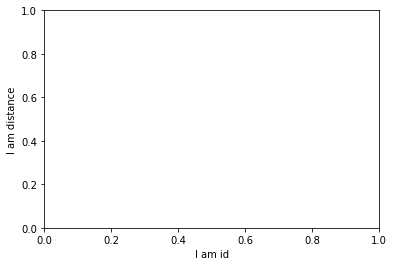

In [66]:
import matplotlib.pyplot as plt
plt.ylabel('I am distance')
plt.xlabel('I am id')
#plt.legend([L1,L2],['A','B'],loc='upper right')
x1=range(0,len(distance1))
#x2=range(0,len(distance2))
x3=range(0,50)
x4=range(0,50)
plt.plot(x1,distance1,label='A',linewidth=3,color='r',marker='o',
markerfacecolor='r',markersize=12)
plt.show()
#plt.plot(x2,distance2,label='B',linewidth=3,color='r',marker='o',
#markerfacecolor='g',markersize=12)
#plt.show()
#plt.plot(x1,data3,label='C',linewidth=3,color='r',marker='o',
#markerfacecolor='b',markersize=12)
#plt.plot(x2,data4,label='D',linewidth=3,color='r',marker='o',
#markerfacecolor='y',markersize=12)
#plt.show()

In [ ]:
#语义分割

In [ ]:

self.net = fcn_resnet101(pretrained=True,progress=False).cuda()
_ = self.net.eval()
def fcn_mask(self,im):
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    input_batch = torch.tensor(im,dtype=torch.float32).cuda()
    input_batch = input_batch.permute(2,0,1)
    input_batch = 2*input_batch/255.0-1.0
    input_batch = input_batch.unsqueeze(0)
    with torch.no_grad():
        output = net(input_batch)['out'][0]
    output_predictions = output.argmax(0).cpu()
    output_predictions = np.where(output_predictions[:]==15,1,0)
    return output_predictions

def create_mask(self,im_bbox):
    im_fcn = self.fcn_mask(im_bbox)
    re = np.zeros(im_bbox.shape)*255
    #im_fcn_=np.zeros((im_fcn.shape[0],im_fcn.shape[1],3))
    re[:,:,0]=re[:,:,1]=re[:,:,2]=im_fcn
    #re = np.where(re.all()!=[0,0,0], [0,0,0], [255,255,255])
    re = re*im_bbox
    re = re.astype(np.uint8)
    cv2.imshow('mask',re)
    return re

In [ ]:
import matplotlib.pyplot as plt

fig=plt.figure()
plt = fig.gca(projection='3d')
plt.plot(set_A_x,set_A_y,set_A_z,label='Frist line',linewidth=3,color='r',marker='o',
markerfacecolor='w',markersize=12)
plt.plot(set_B_x,set_B_y,set_B_z,label='Frist line',linewidth=3,color='r',marker='o',
markerfacecolor='b',markersize=12)
plt.plot(set_O_x,set_O_y,set_O_z,label='Frist line',linewidth=3,color='r',marker='o',
markerfacecolor='g',markersize=12)
plt.plot(set_C_x,set_C_y,set_C_z,label='Frist line',linewidth=3,color='r',marker='o',
markerfacecolor='y',markersize=12)
plt.plot(set_C_x,set_C_y,set_C_z,label='Frist line',linewidth=3,color='r',marker='o',
markerfacecolor='y',markersize=12)
plt.show()

分类器

test2

In [ ]:
import cv2
import glob
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset,ConcatDataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda:0,1" if torch.cuda.is_available() else "cpu")

In [ ]:
class DataLoader(Dataset):
    def __init__(self, fpath_peoject=[]):
        
        self.labels,self.images = [],[]
        for i in fpath_peoject:
            j = i[1]
            np_im = np.load(i[0])
            self.labels.append(j)
            np_im = np_im.flatten()
            #print(np_im.shape)
            self.images.append(np_im)
                
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        return (self.images[idx],self.labels[idx])
classes=['A','B']
def get_data(path):
    list_train,list_val=[],[]
    for name in glob.glob(path+'/*.npy'):
        name_=name.replace('\\','/')
        if name_.find('A')!=-1:
            list_train.append([name_,0])
        if name_.find('B')!=-1:
            list_train.append([name_,1])
    return list_train
train = get_data('./miniclassify/train_max')  
test = get_data('./miniclassify/test_max') 


In [ ]:

mytraindataset = DataLoader(train)
mytestataset = DataLoader(test)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainloader = torch.utils.data.DataLoader(mytraindataset, batch_size=6,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(mytestataset, batch_size=4,
                                          shuffle=True, num_workers=0)
print(len(trainloader))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(100,1000)
        self.fc3 = nn.Linear(1000,2)
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.99))
PATH='./pytorchmodel/my_max.pth'
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)
        #print(inputs,labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 6 == 0:    # print every 2000 mini-batches
            print('\r [%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss/100),end=' ')
            running_loss = 0.0

print('Finished Training')

torch.save(net.state_dict(), PATH)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

In [ ]:
net.load_state_dict(torch.load(PATH))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),cmap="gray")
    plt.show()
    
dataiter = iter(trainloader)
images,lables= dataiter.next()
print(type(images))
images,lables=images.to(device),lables.to(device)
print(images.shape)
outputs = net(images)
print(images.shape)
_, predicted = torch.max(outputs,1)
print(predicted)
imshow(torchvision.utils.make_grid(images.cpu()))
print('Predicted: ', ' '.join('%11s' % classes[predicted[j]]
                              for j in range(len(images))))

In [ ]:
PATH='./pytorchmodel/my_max.pth'
mynet = torch.load(PATH)
print(mynet['fc1.weight'].shape)
print(mynet['fc3.weight'].shape)
#print(mynet)
#print(type(mynet))
W = mynet['fc1.weight']
W_weight=[]
for i in range(0,100):
    #print(W[:,i].shape)
    W_weight.append(np.mean(abs(W[:,i]).cpu().numpy()))
print(W_weight)

In [ ]:
import matplotlib.pyplot as plt
x1=range(0,100)
plt.plot(x1,W_weight,label='Frist line',linewidth=3,color='r',marker='o',
markerfacecolor='blue',markersize=12)

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import cv2
import glob

# Number of EigenFaces
NUM_EIGEN_FACES = 10

# Maximum weight
MAX_SLIDER_VALUE = 10

# Directory containing images
dirName = "./pytorchdata/test"

# Read images
images=[]
for name in glob.glob(dirName+'/*.jpg'):
    #print(name)
    images.append(cv2.resize(cv2.imread(name.replace('\\','/')),(64,128)))
    cv2.imshow('0-0',cv2.imread(name.replace('\\','/')))
    cv2.waitKey(1)

# Size of images
sz = images[0].shape

# Create data matrix for PCA.
data = createDataMatrix(images)

# Compute the eigenvectors from the stack of images created
print("Calculating PCA ", end="...")
mean, eigenVectors = cv2.PCACompute(data, mean=None, maxComponents=NUM_EIGEN_FACES)
print(mean.shape, eigenVectors.shape)
print ("DONE")

averageFace = mean.reshape(sz)
print(averageFace.shape)
cv2.imshow('averageFace',averageFace)
eigenFaces = []; 

for eigenVector in eigenVectors:
    eigenFace = eigenVector.reshape(sz)
    eigenFaces.append(eigenFace)

# Create window for displaying Mean Face
cv2.namedWindow("Result", cv2.WINDOW_AUTOSIZE)

# Display result at 2x size
output = cv2.resize(averageFace, (0,0), fx=2, fy=2)
cv2.imshow("Result", output)

# Create Window for trackbars
cv2.namedWindow("Trackbars", cv2.WINDOW_AUTOSIZE)

sliderValues = []

# Create Trackbars
for i in range(0, NUM_EIGEN_FACES):
    sliderValues.append(MAX_SLIDER_VALUE/2)
    cv2.createTrackbar( "Weight" + str(i), "Trackbars", int(MAX_SLIDER_VALUE), MAX_SLIDER_VALUE, createNewFace)

# You can reset the sliders by clicking on the mean image.
cv2.setMouseCallback("Result", createNewFace);

print('''Usage:
Change the weights using the sliders
Click on the result window to reset sliders
Hit ESC to terminate program.''')

cv2.waitKey(0)
cv2.destroyAllWindows()
